# Basic cell optics
In this script, we will build on the TMM model from the previous example and look at the effects of interference.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from solcore import material, si
from solcore.solar_cell import Layer
from solcore.absorption_calculator import calculate_rat, OptiStack
import seaborn as sns

## Setting up

First, let's define some materials:

In [18]:
Si = material("Si")
SiN = material("Si3N4")()
Ag = material("Ag")()

Note the second set of brackets (or lack thereof). The Solcore material system essentially operates in two stages; we first
call the `material` function with the name of the material we want to use, for example Si = material("Si"), which creates
a general Python class corresponding to that material. We then call this class to specify further details, such as the
temperature, doping level, or alloy composition (where relavant). This happens below when defining Si_n and Si_p; both
are use the Si class defined above, and adding further details to the material. For the definitions of SiN and Ag above,
we do both steps in a single line, hence the two sets of brackets.

In [19]:
Si_n = Si(Nd=si("1e21cm-3"), hole_diffusion_length=si("10um"))
Si_p = Si(Na=si("1e16cm-3"), electron_diffusion_length=si("400um"))

To look at the effect of interference in the Si layer at different thicknesses, we make a list of thicknesses to test
(evenly spaced on a log scale from 400 nm to 300 um):

In [20]:
Si_thicknesses = np.linspace(np.log(0.4e-6), np.log(300e-6), 8)
Si_thicknesses = np.exp(Si_thicknesses)

wavelengths = si(np.linspace(300, 1200, 400), "nm")

options = {
    "recalculate_absorption": True,
    "optics_method": "TMM",
    "wavelength": wavelengths
           }

Make a color palette using the seaborn package to make the plots look nicer

In [21]:
colors = sns.color_palette('rocket', n_colors=len(Si_thicknesses))
colors.reverse()

create an ARC layer:

In [22]:
ARC_layer = Layer(width=si('75nm'), material=SiN)

## Effect of Si thickness

Now we are going to loop through the different Si thicknesses generated above, and create a simple solar cell-like structure.
Because we will only do an optical calculation, we don't need to define a junction and can just make a simple stack of layers.

We then calculate reflection, absorption and transmission (RAT) for two different situations:
1. a fully coherent stack
2. assuming the silicon layer is incoherent. This means that light which enters the Si layer cannot interfere with itself,
    but light in the ARC layer can still show interference. In very thick layers (much thicker than the wavelength of light
    being considered) this is likely to be more physically accurate because real light does not have infinite coherence length;
    i.e. if you measured wavelength-dependent transmission or reflection of a Si wafer hundreds of microns thick you would
    not expect to see interference fringes.

**PLOT 1**

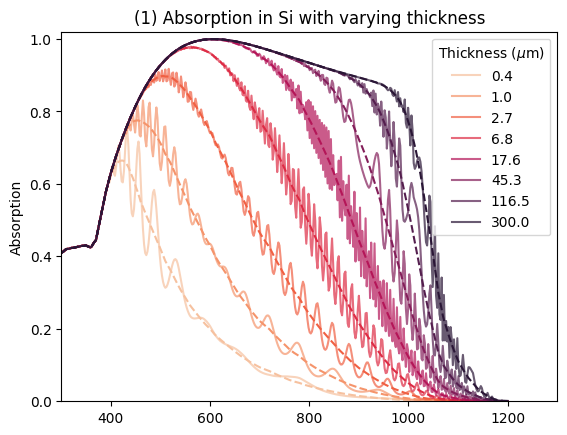

In [23]:
plt.figure()

for i1, Si_t in enumerate(Si_thicknesses):

    base_layer = Layer(width=Si_t, material=Si_p) # silicon layer
    solar_cell = OptiStack([ARC_layer, base_layer]) # OptiStack (optical stack) to feed into calculate_rat function

    # Coherent calculation:
    RAT_c = calculate_rat(solar_cell, wavelengths*1e9, no_back_reflection=False) # coherent calculation
    # For historical reasons, Solcore's default setting is to ignore reflection at the back of the cell (i.e. at the
    # interface between the final material in the stack and the substrate). Hence we need to tell the calculate_rat
    # function NOT to ignore this reflection (no_back_reflection=False).

    # Calculation assuming no interference in the silicon ("incoherent"):
    RAT_i = calculate_rat(solar_cell, wavelengths*1e9, no_back_reflection=False,
                          coherent=False, coherency_list=['c', 'i']) # partially coherent: ARC is coherent, Si is not

    # Plot the results:
    plt.plot(wavelengths*1e9, RAT_c["A"], color=colors[i1], label=str(round(Si_t*1e6, 1)), alpha=0.7)
    plt.plot(wavelengths*1e9, RAT_i["A"], '--', color=colors[i1])

plt.legend(title=r"Thickness ($\mu$m)")
plt.xlim(300, 1300)
plt.ylim(0, 1.02)
plt.ylabel("Absorption")
plt.title("(1) Absorption in Si with varying thickness")
plt.show()

We can see that the coherent calculations (solid lines) show clear interference fringes which depend on the Si thickness.
The incoherent calculations do not have these fringes and seem to lie around the average of the interference fringes.
For both sets of calculations, we see increasing absorption as the Si gets thicker, as expected.

## Effect of reflective substrate

Now we repeat the calculation, but with an Ag substrate under the Si. Previously, we did not specify the substrate and
so it was assumed by Solcore to be air ($n$ = 1, $\kappa$ = 0).


**PLOT 2**

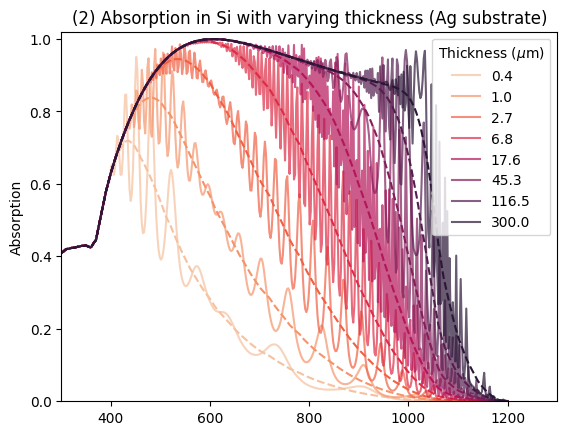

In [24]:
plt.figure()

for i1, Si_t in enumerate(Si_thicknesses):

    base_layer = Layer(width=Si_t, material=Si_p)

    # As before, but now we specify the substrate to be silver:
    solar_cell = OptiStack([ARC_layer, base_layer], substrate=Ag)

    RAT_c = calculate_rat(solar_cell, wavelengths*1e9, no_back_reflection=False)
    RAT_i = calculate_rat(solar_cell, wavelengths*1e9, no_back_reflection=False,
                          coherent=False, coherency_list=['c', 'i'])
    plt.plot(wavelengths*1e9, RAT_c["A"], color=colors[i1],
             label=str(round(Si_t*1e6, 1)), alpha=0.7)
    plt.plot(wavelengths*1e9, RAT_i["A"], '--', color=colors[i1])

plt.legend(title=r"Thickness ($\mu$m)")
plt.xlim(300, 1300)
plt.ylim(0, 1.02)
plt.ylabel("Absorption")
plt.title("(2) Absorption in Si with varying thickness (Ag substrate)")
plt.show()

We see that the interference fringes get more prominent in the coherent calculation, due to higher reflection at the rear
Si/Ag surface compared to Ag/Air. We also see a slightly boosted absorption at long wavelengths at all thicknesses, again
due to improved reflection at the rear surface

## Effect of polarization and angle of incidence

Finally, we look at the effect of incidence angle and polarization of the light hitting the cell.

**PLOT 3**

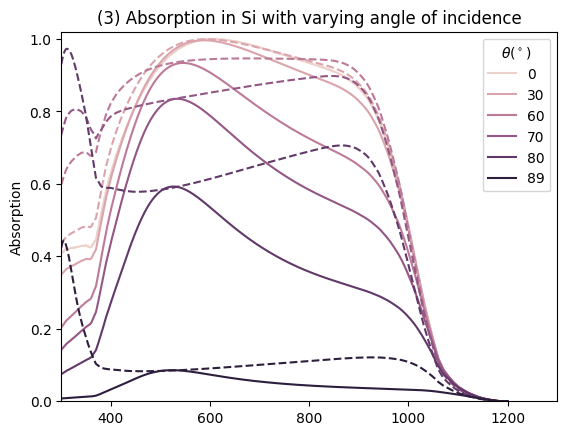

In [26]:
angles = [0, 30, 60, 70, 80, 89] # angles in degrees

ARC_layer = Layer(width=si('75nm'), material=SiN)
base_layer = Layer(width=si("100um"), material=Si_p)

colors = sns.cubehelix_palette(n_colors=len(angles))

plt.figure()

for i1, theta in enumerate(angles):

    solar_cell = OptiStack([ARC_layer, base_layer])

    RAT_s = calculate_rat(solar_cell, wavelengths*1e9, angle=theta,
                          pol='s',
                          no_back_reflection=False,
                          coherent=False, coherency_list=['c', 'i'])
    RAT_p = calculate_rat(solar_cell, wavelengths*1e9, angle=theta,
                          pol='p',
                          no_back_reflection=False,
                          coherent=False, coherency_list=['c', 'i'])

    plt.plot(wavelengths*1e9, RAT_s["A"], color=colors[i1], label=str(round(theta)))
    plt.plot(wavelengths*1e9, RAT_p["A"], '--', color=colors[i1])

plt.legend(title=r"$\theta (^\circ)$")
plt.xlim(300, 1300)
plt.ylim(0, 1.02)
plt.ylabel("Absorption")
plt.title("(3) Absorption in Si with varying angle of incidence")
plt.show()

For normal incidence ($\theta = 0^\circ$), *s* (solid lines) and *p* (dashed lines) polarization are equivalent. As the incidence
angle increases, in general absorption is higher for p-polarized light (due to lower reflection). 

## Conclusions

We have now seen some effects of interference in layers of different thicknesses, and seen the effect of adding a highly
reflective substrate. So we already have two strategies for light-trapping/improving the absorption in a solar cell:
adding an anti-reflection coating (in example 1a), to reduce front-surface reflection and get more light into the cell,
and adding a highly reflective layer at the back, to reduce loss through the back of the cell and keep light trapped in
the cell.

## Questions

- Why are the interference fringes stronger when adding a silver back mirror,
  compared to having air behind the Si?
- We modelled s and p-polarized light - how do we normally model unpolarized light?